In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import plotly.express as px
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

Mounted at /content/drive


In [2]:
# data preprocess
gdf_3 = gpd.read_file(f'/content/drive/My Drive/Mantises!/data/gadm41_USA_shp/gadm41_USA_2.shp')
gdf_3 = gdf_3[(gdf_3['NAME_1'] == 'California') & (gdf_3['TYPE_2'] == 'County')]

df = pd.read_csv(f'/content/drive/My Drive/Mantises!/data/mantodea_ca_gbif_simple.csv', sep='\t')

In [3]:
species_df = df[['species', 'decimalLatitude', 'decimalLongitude', 'elevation', 'depth']]

In [4]:
from shapely.geometry import Point

# Create a new geometry column in your pandas dataframe
geometry = [Point(xy) for xy in zip(species_df.decimalLongitude, species_df.decimalLatitude)]
geo_species_df = gpd.GeoDataFrame(species_df, geometry=geometry)


In [5]:
geo_species_df.set_crs(epsg=4326, inplace=True)

gdf_3.set_crs(epsg=4326, inplace=True)
# If necessary, transform one of the dataframes to match the other's CRS
geo_species_df = geo_species_df.to_crs(gdf_3.crs)

In [6]:
joined = gpd.sjoin(geo_species_df, gdf_3, how="inner", op="intersects")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
joined.head()

,species,decimalLatitude,decimalLongitude,elevation,depth,geometry,index_right,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,Mantis religiosa,38.569964,-122.689257,NaN,NaN,POINT (-122.68926 38.56996),231,USA.5.49_1,USA,United States,USA.5_1,California,NA,Sonoma,NA,NA,County,County,NA,US.CA.SO
2,Mantis religiosa,38.569659,-122.689175,NaN,NaN,POINT (-122.68918 38.56966),231,USA.5.49_1,USA,United States,USA.5_1,California,NA,Sonoma,NA,NA,County,County,NA,US.CA.SO
9,Mantis religiosa,38.624724,-122.871580,NaN,NaN,POINT (-122.87158 38.62472),231,USA.5.49_1,USA,United States,USA.5_1,California,NA,Sonoma,NA,NA,County,County,NA,US.CA.SO
10,Mantis religiosa,38.575230,-122.693980,NaN,NaN,POINT (-122.69398 38.57523),231,USA.5.49_1,USA,United States,USA.5_1,California,NA,Sonoma,NA,NA,County,County,NA,US.CA.SO
11,Mantis religiosa,38.584350,-122.699930,NaN,NaN,POINT (-122.69993 38.58435),231,USA.5.49_1,USA,United States,USA.5_1,California,NA,Sonoma,NA,NA,County,County,NA,US.CA.SO


In [8]:
population_df = pd.read_csv(f'/content/drive/My Drive/Mantises!/data/ACSDT5Y2020.B01003-Data.csv')

In [9]:
county_size_df = pd.read_csv(f'/content/drive/My Drive/Mantises!/data/California_Counties_Area.csv')

In [10]:
county_density_df = pd.merge(county_size_df, population_df, on='County')

In [11]:
county_density_df['human_population_density'] = county_density_df['Population Total'] / county_density_df['Land Area (sq mi)']

In [12]:
joined = joined.rename(columns = {'NAME_2': 'County'})

In [13]:
joined = joined[['species', 'decimalLatitude', 'decimalLongitude', 'elevation', 'depth', 'geometry', 'County']]

In [14]:
all_data = pd.merge(joined, county_density_df, on='County')

In [15]:
all_data.head()

,species,decimalLatitude,decimalLongitude,elevation,depth,geometry,County,Rank,Land Area (sq mi),Population Total,human_population_density
0,Mantis religiosa,38.569964,-122.689257,NaN,NaN,POINT (-122.68926 38.56996),Sonoma,29,1575.63,496801,315.303085
1,Mantis religiosa,38.569659,-122.689175,NaN,NaN,POINT (-122.68918 38.56966),Sonoma,29,1575.63,496801,315.303085
2,Mantis religiosa,38.624724,-122.871580,NaN,NaN,POINT (-122.87158 38.62472),Sonoma,29,1575.63,496801,315.303085
3,Mantis religiosa,38.575230,-122.693980,NaN,NaN,POINT (-122.69398 38.57523),Sonoma,29,1575.63,496801,315.303085
4,Mantis religiosa,38.584350,-122.699930,NaN,NaN,POINT (-122.69993 38.58435),Sonoma,29,1575.63,496801,315.303085


In [16]:
all_data = all_data.drop('Rank', axis=1)

In [17]:
all_data.columns
status = {
    'Mantis religiosa': 'introduced',
    'Stagmomantis californica': 'native',
    'Litaneutria pacifica': 'native',
    'Litaneutria skinneri': 'native',
    'Stagmomantis limbata': 'native',
    'Iris oratoria': 'introduced',
    'Miomantis caffra': 'introduced',
    'Litaneutria ocularis': 'native',
    'Tenodera sinensis': 'introduced',
    'Litaneutria chaparrali': 'native',
    'Hierodula patellifera': 'introduced',
    'Litaneutria minor': 'native',
    'Yersiniops newboldi': 'native',
    'Thesprotia graminis': 'native'
}


all_data['native'] = all_data['species'].map(status)

In [18]:
all_data.head()

,species,decimalLatitude,decimalLongitude,elevation,depth,geometry,County,Land Area (sq mi),Population Total,human_population_density,native
0,Mantis religiosa,38.569964,-122.689257,NaN,NaN,POINT (-122.68926 38.56996),Sonoma,1575.63,496801,315.303085,introduced
1,Mantis religiosa,38.569659,-122.689175,NaN,NaN,POINT (-122.68918 38.56966),Sonoma,1575.63,496801,315.303085,introduced
2,Mantis religiosa,38.624724,-122.871580,NaN,NaN,POINT (-122.87158 38.62472),Sonoma,1575.63,496801,315.303085,introduced
3,Mantis religiosa,38.575230,-122.693980,NaN,NaN,POINT (-122.69398 38.57523),Sonoma,1575.63,496801,315.303085,introduced
4,Mantis religiosa,38.584350,-122.699930,NaN,NaN,POINT (-122.69993 38.58435),Sonoma,1575.63,496801,315.303085,introduced


In [19]:
# getting climate data
climate_data = pd.read_csv(f'/content/drive/My Drive/Mantises!/output/climatic_data/climatic_data_20231206_050035.csv')

In [20]:
climate_data.head()

,State,County,Year,Month,prcp,tmax,tmin
0,California,Alameda,1980,1,115.634125,NaN,NaN
1,California,Alpine,1980,1,361.815216,NaN,NaN
2,California,Amador,1980,1,320.292175,NaN,NaN
3,California,Butte,1980,1,286.148041,NaN,NaN
4,California,Calaveras,1980,1,332.901245,NaN,NaN


In [21]:
climate_data = climate_data[['County', 'prcp', 'tmax', 'tmin']]
climate_data = climate_data.groupby('County').mean()

In [22]:
climate_data.head()

,prcp,tmax,tmin
County,,,
Alameda,40.319967,20.904928,9.695275
Alpine,81.807864,12.457218,-0.429198
Amador,80.838894,20.845305,7.341989
Butte,96.290673,22.181397,8.452543
Calaveras,78.762067,21.392718,7.554954


In [23]:
all_data = pd.merge(all_data, climate_data, on='County')

In [24]:
all_data.head()

,species,decimalLatitude,decimalLongitude,elevation,depth,geometry,County,Land Area (sq mi),Population Total,human_population_density,native,prcp,tmax,tmin
0,Mantis religiosa,38.569964,-122.689257,NaN,NaN,POINT (-122.68926 38.56996),Sonoma,1575.63,496801,315.303085,introduced,93.391093,20.492571,7.783081
1,Mantis religiosa,38.569659,-122.689175,NaN,NaN,POINT (-122.68918 38.56966),Sonoma,1575.63,496801,315.303085,introduced,93.391093,20.492571,7.783081
2,Mantis religiosa,38.624724,-122.871580,NaN,NaN,POINT (-122.87158 38.62472),Sonoma,1575.63,496801,315.303085,introduced,93.391093,20.492571,7.783081
3,Mantis religiosa,38.575230,-122.693980,NaN,NaN,POINT (-122.69398 38.57523),Sonoma,1575.63,496801,315.303085,introduced,93.391093,20.492571,7.783081
4,Mantis religiosa,38.584350,-122.699930,NaN,NaN,POINT (-122.69993 38.58435),Sonoma,1575.63,496801,315.303085,introduced,93.391093,20.492571,7.783081


In [25]:
features = ['decimalLatitude', 'decimalLongitude', 'human_population_density', 'prcp', 'tmin', 'tmax']
label = 'native'


In [26]:
c_range = [10e-12, 10e-8, 10e-4, 10e-1, 1, 10, 100, 1000]
gamma_range = [10e-12, 10e-8, 10e-4, 10e-1, 1, 10, 100, 1000, 10e4, 10e5, 10e6]

no_na_data = all_data[features + [label]].dropna()





from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(no_na_data, test_size=0.2, random_state=42)




train_accuracy_holder = {'Gamma': [], 'C': [], 'Train Accuracy': []}

for c in c_range:
  for gamma in gamma_range:
    # default kernel is rbf (Gaussian) kernel

    clf= SVC(gamma=gamma, C=c)
    clf.fit(train_df[features], train_df[label])
    predictions = clf.predict(train_df[features])

    train_accuracy = accuracy_score(predictions, train_df[label])


    train_accuracy_holder['Gamma'].append(gamma)
    train_accuracy_holder['C'].append(c)
    train_accuracy_holder['Train Accuracy'].append(train_accuracy)


train_accuracy_df = pd.DataFrame(train_accuracy_holder)
train_accuracy_df.head()

,Gamma,C,Train Accuracy
0,1.000000e-11,1.000000e-11,0.506194
1,1.000000e-07,1.000000e-11,0.506194
2,1.000000e-03,1.000000e-11,0.506194
3,1.000000e+00,1.000000e-11,0.506194
4,1.000000e+00,1.000000e-11,0.506194


In [27]:
min_max_holder = {'Min C': [], 'Max C': [], 'Min Gamma': [], 'Max Gamma': []}

min_gamma = min(train_accuracy_df[(train_accuracy_df['Train Accuracy'] > 0.7)]['Gamma'])
max_gamma = max(train_accuracy_df[(train_accuracy_df['Train Accuracy'] > 0.7) ]['Gamma'])

min_c = min(train_accuracy_df[(train_accuracy_df['Train Accuracy'] > 0.7) ]['C'])
max_c = max(train_accuracy_df[(train_accuracy_df['Train Accuracy'] > 0.7) ]['C'])

min_max_holder['Min C'].append(min_c)
min_max_holder['Max C'].append(max_c)
min_max_holder['Min Gamma'].append(min_gamma)
min_max_holder['Max Gamma'].append(max_gamma)
pd.DataFrame(min_max_holder)

,Min C,Max C,Min Gamma,Max Gamma
0,1.0,1000.0,1.000000e-07,10000000.0


In [28]:
c_cross_val_range = [i for i in range(int(min_max_holder['Min C'][0]),int(min_max_holder['Max C'][0]) + 1,  int(min_max_holder['Max C'][0]) // 5)]

gamma_cross_val_range = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10, 10e2, 10e3, 10e4, 10e5, 10e6, 10e7]

params = {'C': c_cross_val_range, 'gamma': gamma_cross_val_range
}

best_cross_val_result_holder = {}


grid_search = GridSearchCV(SVC(kernel='rbf'), params, cv=10, n_jobs=-1)
grid_search.fit(train_df[features], train_df[label])

best_cross_val_result_holder['Best C'] = grid_search.best_params_['C']
best_cross_val_result_holder['Best Gamma'] = grid_search.best_params_['gamma']

In [29]:
clf= SVC(gamma=best_cross_val_result_holder['Best Gamma'], C=best_cross_val_result_holder['Best C'])
clf.fit(train_df[features], train_df[label])
prediction_holder = clf.predict(test_df[features])

In [30]:
print(f'Test Accuracy: {accuracy_score(test_df[label], prediction_holder)}')

Test Accuracy: 0.829954954954955


In [31]:
print(best_cross_val_result_holder)

{'Best C': 201, 'Best Gamma': 10}


TEST CONFUSION MATRIX


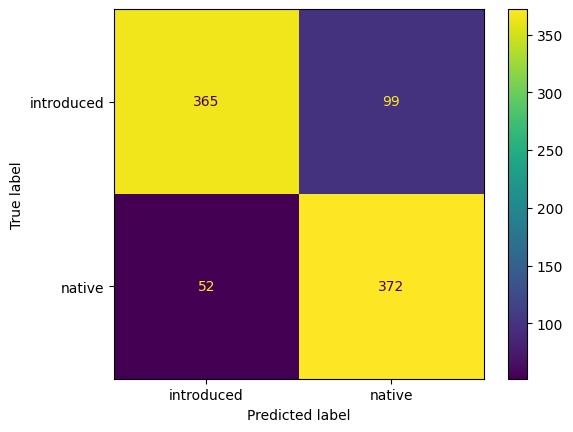

In [32]:
# Test confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
print("TEST CONFUSION MATRIX")
cm = confusion_matrix(test_df[label], prediction_holder, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

TRAIN CONFUSION MATRIX


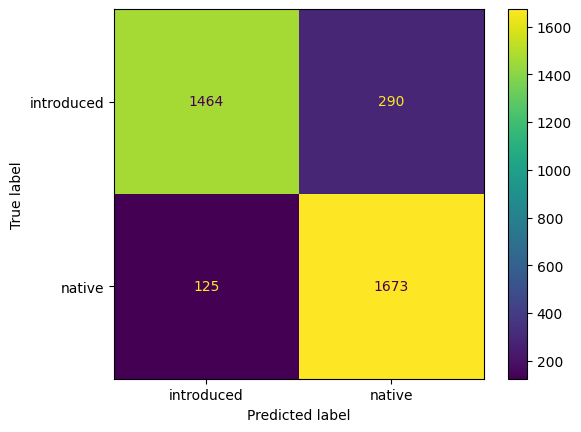

In [33]:
# Train confusion matrix
print("TRAIN CONFUSION MATRIX")
train_preds = clf.predict(train_df[features])
cm = confusion_matrix(train_df[label], train_preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [34]:
print(f'Train Accuracy: {accuracy_score(train_df[label], train_preds)}')

Train Accuracy: 0.8831644144144144


In [35]:
# repeat same process for linear kernel!

c_range = [10e-12, 10e-8, 10e-4, 10e-1, 1, 10, 100]
no_na_data = all_data[features + [label]].dropna()





from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(no_na_data, test_size=0.2, random_state=42)




train_accuracy_holder = { 'C': [], 'Train Accuracy': []}

for c in c_range:

  clf= SVC(kernel='linear', C=c, max_iter=999999)
  clf.fit(train_df[features], train_df[label])
  predictions = clf.predict(train_df[features])

  train_accuracy = accuracy_score(predictions, train_df[label])

  train_accuracy_holder['C'].append(c)
  train_accuracy_holder['Train Accuracy'].append(train_accuracy)


train_accuracy_df = pd.DataFrame(train_accuracy_holder)
train_accuracy_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=999999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=999999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=999999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=999999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=999999).

,C,Train Accuracy
0,1.000000e-11,0.506194
1,1.000000e-07,0.620495
2,1.000000e-03,0.716498
3,1.000000e+00,0.648649
4,1.000000e+00,0.648649


In [36]:
min_max_holder = {'Min C': [], 'Max C': []}

min_c = min(train_accuracy_df[(train_accuracy_df['Train Accuracy'] > 0.7) ]['C'])
max_c = max(train_accuracy_df[(train_accuracy_df['Train Accuracy'] > 0.7) ]['C'])

min_max_holder['Min C'].append(min_c)
min_max_holder['Max C'].append(max_c)

In [39]:
c_cross_val_range = [0.01, 0.03, 0.05, 0.09, 0.1]



params = {'C': c_cross_val_range
}

best_cross_val_result_holder = {}


grid_search = GridSearchCV(SVC(kernel='linear', max_iter=999999), params, cv=5, n_jobs=-1)
grid_search.fit(train_df[features], train_df[label])

best_cross_val_result_holder['Best C'] = grid_search.best_params_['C']

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=999999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [40]:
clf= SVC(kernel='linear', C=best_cross_val_result_holder['Best C'], max_iter=999999)
clf.fit(train_df[features], train_df[label])
prediction_holder = clf.predict(test_df[features])

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=999999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [41]:
print(f'Test Accuracy: {accuracy_score(test_df[label], prediction_holder)}')

Test Accuracy: 0.7308558558558559


TEST CONFUSION MATRIX


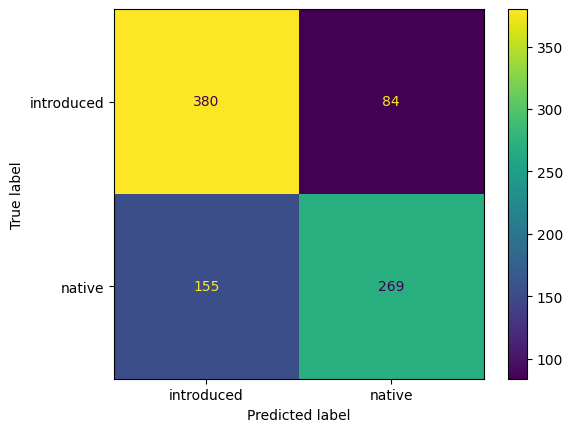

In [42]:
print("TEST CONFUSION MATRIX")
cm = confusion_matrix(test_df[label], prediction_holder, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

TRAIN CONFUSION MATRIX


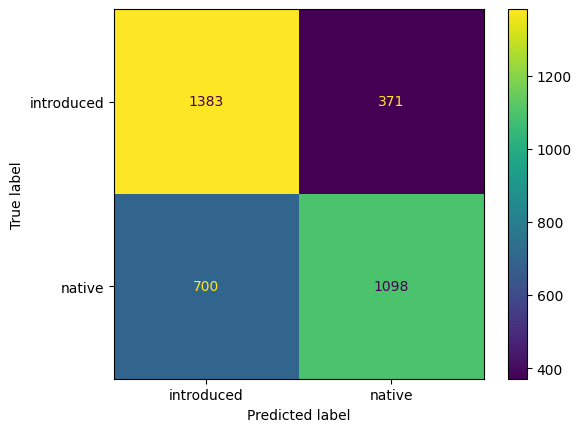

In [43]:
print("TRAIN CONFUSION MATRIX")
train_preds = clf.predict(train_df[features])
cm = confusion_matrix(train_df[label], train_preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [44]:
print(f'Train Accuracy: {accuracy_score(train_df[label], train_preds)}')

Train Accuracy: 0.6984797297297297


In [45]:
# native vs non native distribution
all_data['native'].value_counts()


native        2222
introduced    2218
Name: native, dtype: int64